# Utqiagvik Analysis
- This notebook reads cropped the SSMI CDR data around Alaska to make file for Utqiagvik
- Note: the SSMI data is on the 25x25km EASE grid
- Notebook by Alice DuVivier (NCAR)
- October 2025

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from glob import glob
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load data

In [4]:
# directory path
dir_in = '/glade/campaign/cgd/ppc/duvivier/arctic_actionable/DATA/ssmi_cdr/'
file_in = 'cdr_seaice_conc_daily_alaska.noleap.19790101-20211231.nc'

In [5]:
ds = xr.open_mfdataset(dir_in+file_in, decode_times=False)

In [6]:
# look at dataset
ds

<xarray.Dataset>
Dimensions:                (idim: 100, jdim: 140, time: 15695)
Coordinates:
  * time                   (time) int64 0 1 2 3 4 ... 15702 15703 15704 15705
  * jdim                   (jdim) float32 3.338e+06 3.312e+06 ... -1.375e+05
  * idim                   (idim) float32 -3.838e+06 -3.812e+06 ... -1.362e+06
Data variables:
    xgrid                  (idim, jdim) float32 dask.array<chunksize=(100, 140), meta=np.ndarray>
    ygrid                  (jdim, idim) float32 dask.array<chunksize=(140, 100), meta=np.ndarray>
    latitude               (jdim, idim) float64 dask.array<chunksize=(140, 100), meta=np.ndarray>
    longitude              (jdim, idim) float64 dask.array<chunksize=(140, 100), meta=np.ndarray>
    cdr_seaice_conc_daily  (time, jdim, idim) float32 dask.array<chunksize=(15695, 140, 100), meta=np.ndarray>
Attributes:
    creation_date:      Thu Nov 10 18:09:48 MST 2022
    creation_author:    Laura Landrum
    creation_program:   /glade/u/home/landrum/SSMI/concatenate_daily_ssmi.ncl
    processing_author:  Alice DuVivier
    processing_date:    2024-06-06
    contents:           Alaska regional SSMI CDR daily sea ice concentration ...

In [7]:
# look at variable of interest
ds.cdr_seaice_conc_daily

<xarray.DataArray 'cdr_seaice_conc_daily' (time: 15695, jdim: 140, idim: 100)>
dask.array<open_dataset-cdr_seaice_conc_daily, shape=(15695, 140, 100), dtype=float32, chunksize=(15695, 140, 100), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 15700 15701 15702 15703 15704 15705
  * jdim     (jdim) float32 3.338e+06 3.312e+06 ... -1.125e+05 -1.375e+05
  * idim     (idim) float32 -3.838e+06 -3.812e+06 ... -1.388e+06 -1.362e+06
Attributes:
    units:      %
    long_name:  cdr_seaice_conc concatenated from /glade/scratch/landrum/NSID...

### Modify the time bound

In [8]:
# check out the time info - find that it's not intuitive
ds.time

<xarray.DataArray 'time' (time: 15695)>
array([    0,     1,     2, ..., 15703, 15704, 15705])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 15700 15701 15702 15703 15704 15705
Attributes:
    units:     days since 1979-01-01 00:00:00
    calendar:  proleptic_gregorian

In [9]:
# to make useable time coordinate, create arrays for yyyy-mm-dd (NO LEAP!)
# We know it's daily data for 19790101-20211231, not including leap days.

# create full range of dates at daily frequency
dr = pd.date_range(start='1/1/1979', end='12/31/2021', freq='D')
# remove leap days
dates = dr[(dr.day != 29) | (dr.month != 2)]
# check that the # times matches above
print(dates.shape)

(15695,)


In [10]:
# assign the time coordinate
ds['time'] = dates

In [11]:
ds.time

<xarray.DataArray 'time' (time: 15695)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2021-12-29T00:00:00.000000000',
       '2021-12-30T00:00:00.000000000', '2021-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31

### Look at data

Text(0.5, 1.0, 'First timestep data')

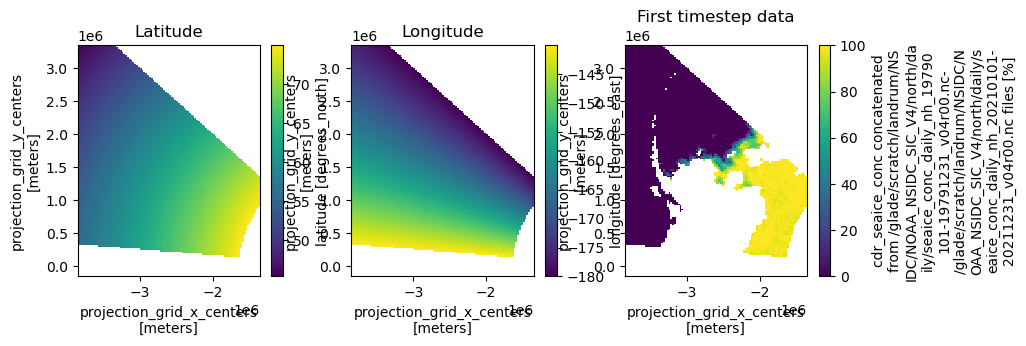

In [12]:
# quick plot of the data
fig,ax=plt.subplots(1,3,figsize=(10,3))
axs=ax.flatten()
# first subplot
ds.latitude.plot(ax=axs[0])
axs[0].set_title('Latitude')
# second subplot
ds.longitude.plot(ax=axs[1])
axs[1].set_title('Longitude')
# third subplot
ds.cdr_seaice_conc_daily.isel(time=0).plot(ax=axs[2])
axs[2].set_title('First timestep data')

### Find grid cell closest to Village

In [13]:
# set latitude and longitude of Village
name_village = 'Utqiagvik'
lat_village = 71.29
lon_village = -156.79

In [14]:
# grab lat and lon data
lat2d = ds.latitude
lon2d = ds.longitude

# mask these by where we do not have data
lat2d = lat2d.where(ds.cdr_seaice_conc_daily.isel(time=0).notnull())
lon2d = lon2d.where(ds.cdr_seaice_conc_daily.isel(time=0).notnull())

In [15]:
# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(lat2d - lat_village)
abslon = np.abs(lon2d - lon_village)
c = np.maximum(abslon, abslat)

# find the smallest values
([xloc], [yloc]) = np.where(c == np.min(c))

# print index values
#print(xloc,yloc)

In [16]:
# Check how close these are to the latitude and longitude of the village
print(name_village+': '+str(lat_village)+','+str(lon_village))

lat_grid = ds.latitude.isel(jdim=xloc,idim=yloc).values
lon_grid = ds.longitude.isel(jdim=xloc,idim=yloc).values
print('grid point: '+str(lat_grid)+','+str(lon_grid))

Utqiagvik: 71.29,-156.79
grid point: 71.3676242774497,-156.997403406642


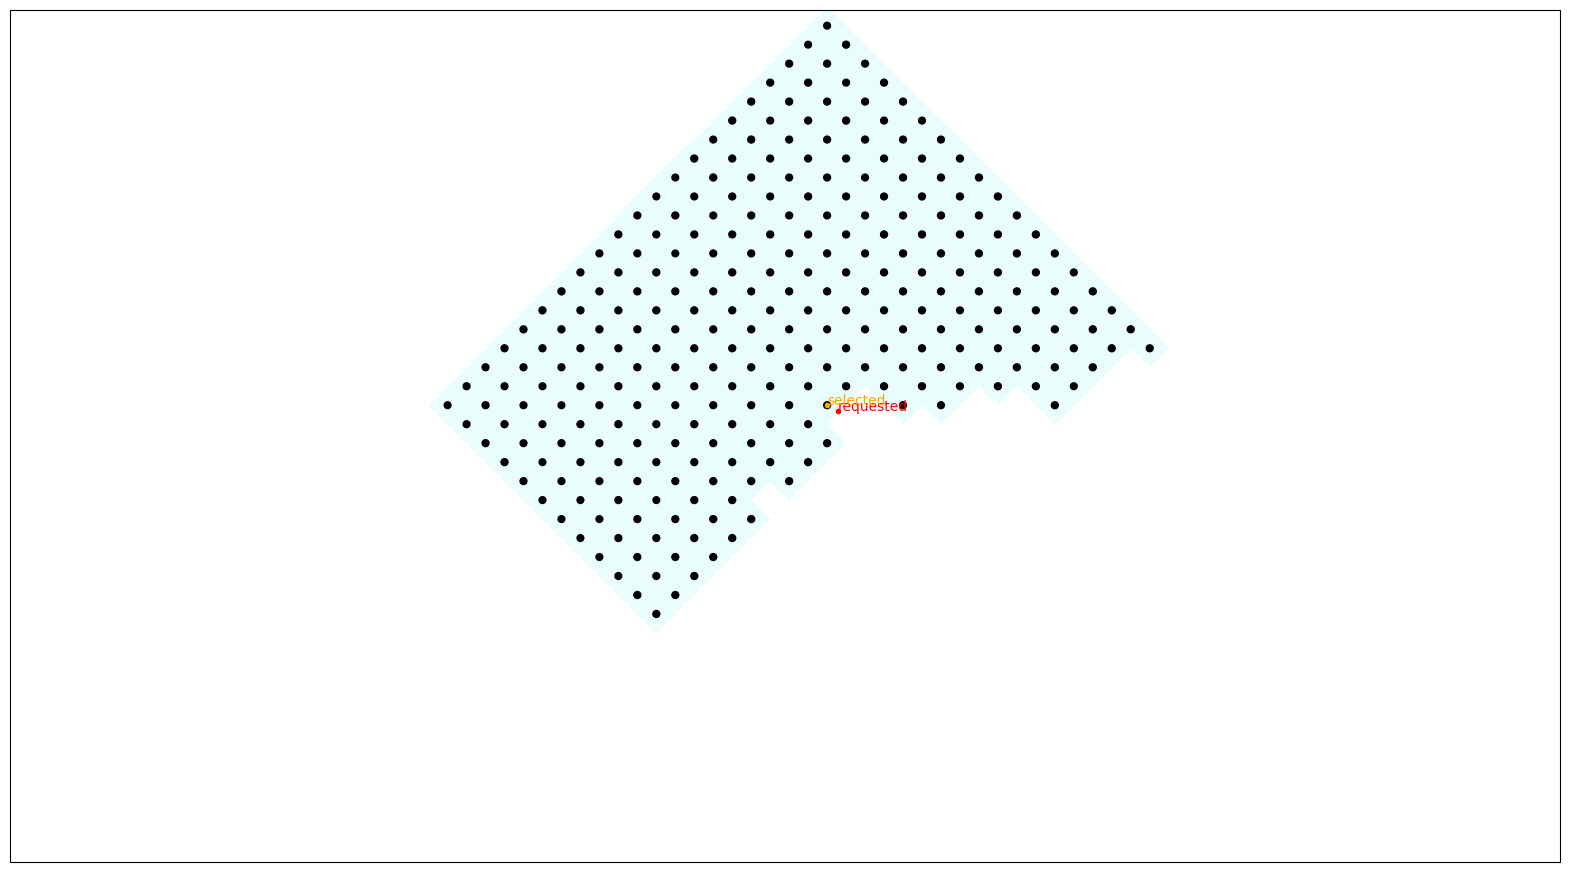

In [17]:
# Plot the Grid points to ensure we have the closest point for plots
fig = plt.figure(figsize=(20,20))

# grab datasubset around this village
ds_subset = ds.isel(jdim=slice(xloc-10,xloc+11),idim=slice(yloc-10,yloc+11))

# make plot
ax = plt.subplot(1,1,1,projection = ccrs.NorthPolarStereo(central_longitude=180.0) )
ax.set_extent([-140, -179, 72, 69], crs=ccrs.PlateCarree())

# do a pcolormesh plot of input
cs0 = ax.pcolormesh(ds_subset.longitude.values, ds_subset.latitude.values,
                    ds_subset.cdr_seaice_conc_daily.isel(time=0),
                    cmap = cmocean.cm.ice, vmax = 1, vmin = 0,
                    transform=ccrs.PlateCarree())

# do scatter plot of all grid values
cs1 = ax.scatter(ds_subset.longitude.values, ds_subset.latitude.values, 
                 ds_subset.cdr_seaice_conc_daily.isel(time=0),
                 c='black',marker='.',
                 transform=ccrs.PlateCarree())

# Plot requested lat/lon point red
cs2 = ax.scatter(lon_village, lat_village, marker='.',c='red', transform=ccrs.PlateCarree())
tx1 = ax.text(lon_village, lat_village, 'requested', c='red', transform=ccrs.PlateCarree())

# Plot nearest point in the array orange
cs4 = plt.scatter(ds.longitude.isel(jdim=xloc,idim=yloc), ds.latitude.isel(jdim=xloc,idim=yloc), marker='.', color='orange', transform=ccrs.PlateCarree())
tx2 = plt.text(ds.longitude.isel(jdim=xloc,idim=yloc), ds.latitude.isel(jdim=xloc,idim=yloc), 'selected', c='orange', transform=ccrs.PlateCarree())
               

### Grab data nearest the village

In [18]:
# grab datasubset at this village
ds_village = ds.cdr_seaice_conc_daily.isel(jdim=slice(xloc,xloc+1),idim=slice(yloc,yloc+1))

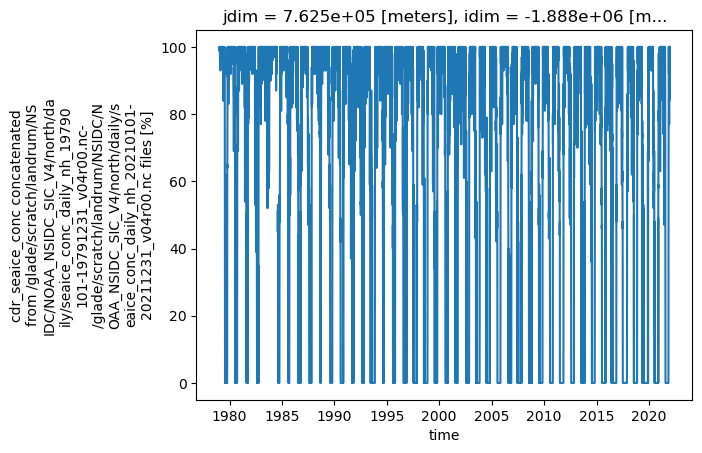

In [19]:
# quick plot to see what this looks like
ds_village.plot()

In [20]:
ds_village

<xarray.DataArray 'cdr_seaice_conc_daily' (time: 15695, jdim: 1, idim: 1)>
dask.array<getitem, shape=(15695, 1, 1), dtype=float32, chunksize=(15695, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
  * jdim     (jdim) float32 7.625e+05
  * idim     (idim) float32 -1.888e+06
Attributes:
    units:      %
    long_name:  cdr_seaice_conc concatenated from /glade/scratch/landrum/NSID...

In [32]:
ds_village = ds_village.isel(jdim=0,idim=0)

In [33]:
ds_village

<xarray.DataArray 'cdr_seaice_conc_daily' (time: 15695)>
dask.array<getitem, shape=(15695,), dtype=float32, chunksize=(15695,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
    jdim     float32 7.625e+05
    idim     float32 -1.888e+06
Attributes:
    units:      %
    long_name:  cdr_seaice_conc concatenated from /glade/scratch/landrum/NSID...

### Deal with some of the dates for calculations below

In [34]:
# get an array of all the years
years_all = ds_village.coords['time.year'][(ds_village.coords['time.month']==1)]
years_all = years_all.coords['time.year'][(years_all.coords['time.day']==1)]
nyears = len(years_all)
print(nyears)

43


In [35]:
# create month arrays
months = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mon_start = [32,60,91,121,152,182,213,244,274,305,335]
nmons = len(month_names)
print(nmons)

12


In [36]:
# get all days
ndays = 365
days_all = np.arange(1,ndays+1,1)
print(ndays)

365


## Save the variable
- Netcdf with variable dimension: (time)

In [37]:
ds_out = xr.Dataset()

ds_out['sic'] = ds_village

# change the attributes
ds_out.attrs['author'] = 'Alice DuVivier'
ds_out.attrs['date_processed'] = datetime.now().strftime('%Y-%m-%d')
ds_out.attrs['contents'] = f'Daily SSMI CDR satellite data for ocean point nearest Utqiagvik'

ds_out

<xarray.Dataset>
Dimensions:  (time: 15695)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2021-12-31
    jdim     float32 7.625e+05
    idim     float32 -1.888e+06
Data variables:
    sic      (time) float32 dask.array<chunksize=(15695,), meta=np.ndarray>
Attributes:
    author:          Alice DuVivier
    date_processed:  2025-09-29
    contents:        Daily SSMI CDR satellite data for ocean point nearest Ut...

In [38]:
# Print the dimensions
print("Dimensions:")
for dim in ds_out.dims:
    print(f"\t{dim}: {ds_out[dim].values.shape}")

# Print the coordinates
print("Coordinates:")
for coord in ds_out.coords:
    print(f"\t{coord}:")
    print(f"\t\t{ds_out.coords[coord].values}")
    
# Print the attributes
print("Attributes:")
for attr in ds_out.attrs:
    print(f"\t{attr}: {ds_out.attrs[attr]}")

Dimensions:
	time: (15695,)
Coordinates:
	time:
		['1979-01-01T00:00:00.000000000' '1979-01-02T00:00:00.000000000'
 '1979-01-03T00:00:00.000000000' ... '2021-12-29T00:00:00.000000000'
 '2021-12-30T00:00:00.000000000' '2021-12-31T00:00:00.000000000']
	jdim:
		762500.0
	idim:
		-1887500.0
Attributes:
	author: Alice DuVivier
	date_processed: 2025-09-29
	contents: Daily SSMI CDR satellite data for ocean point nearest Utqiagvik


## Export and Save

In [39]:
# calculate the size of the dataset in GB
size_gb = ds_out.nbytes / (1024**3)
print(f"The dataset is approximately {size_gb:.2f} GB.")

The dataset is approximately 0.00 GB.


In [44]:
path_out = dir_in
file_out = name_village+'_SSMI_CDR_1979-2021_daily-SIC.nc'
fout = path_out + file_out

In [45]:
# Export the dataset to NetCDF with all attributes and coordinates
ds_out.to_netcdf(fout)